In [2]:
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [3]:
#df.set_index('Data', inplace=True)
#df=df.drop('2016-02-29', axis=0)
#df=df.drop('2020-02-29', axis=0)
#df.head()

In [4]:
#df=df.reset_index()
#df.head()

In [5]:
#trasformo le date e i numeri
df.Data = pd.to_datetime(df.Data, dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [6]:
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,151
2015-01-02,160
2015-01-03,145
2015-01-04,153
2015-01-05,171


In [87]:
#creo la time series
ts = df.Totale
ts.tail()

Data
2020-04-26    125
2020-04-27    141
2020-04-28    126
2020-04-29    116
2020-04-30    103
Name: Totale, dtype: int64

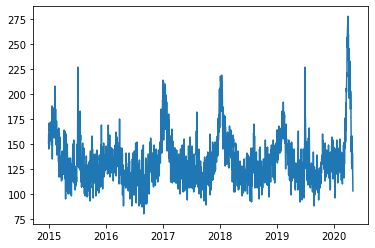

In [59]:
plt.plot(ts)

In [8]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

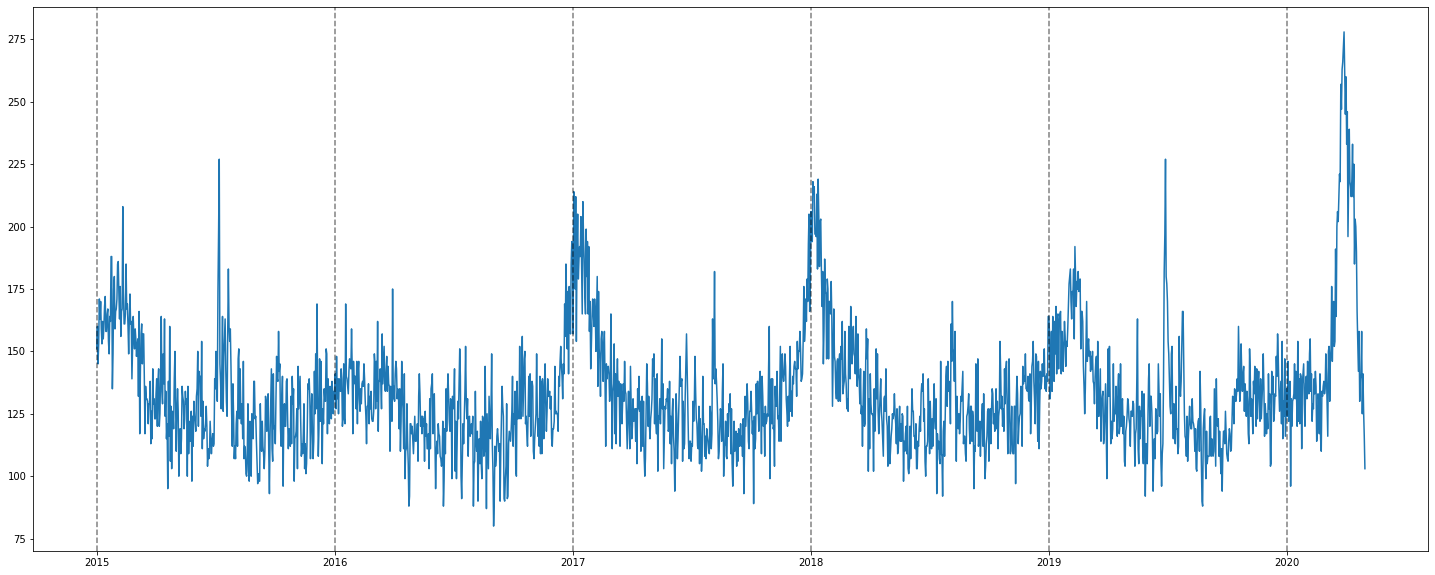

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

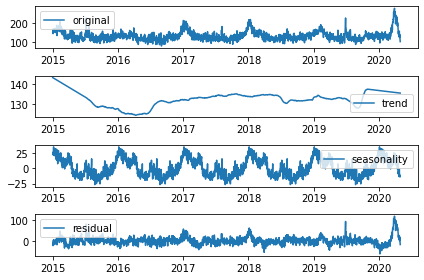

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365,two_sided=True,extrapolate_trend=1)

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [89]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

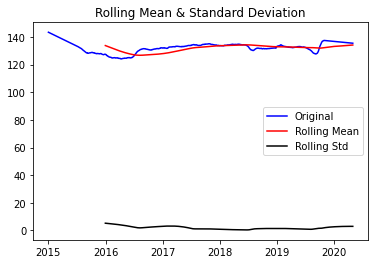

Results of Dickey-Fuller Test:
Test Statistic                   -3.114611
p-value                           0.025491
#Lags Used                        9.000000
Number of Observations Used    1937.000000
Critical Value (1%)              -3.433730
Critical Value (5%)              -2.863033
Critical Value (10%)             -2.567565
dtype: float64
X is not stationary


In [90]:
test_stationarity(ts_trend.dropna())

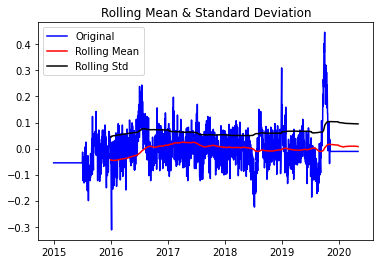

Results of Dickey-Fuller Test:
Test Statistic                -5.718177e+00
p-value                        7.041233e-07
#Lags Used                     8.000000e+00
Number of Observations Used    1.937000e+03
Critical Value (1%)           -3.433730e+00
Critical Value (5%)           -2.863033e+00
Critical Value (10%)          -2.567565e+00
dtype: float64
X is stationary


In [91]:
ts_trend_diff = ts_trend.diff()
test_stationarity(ts_trend_diff.dropna())

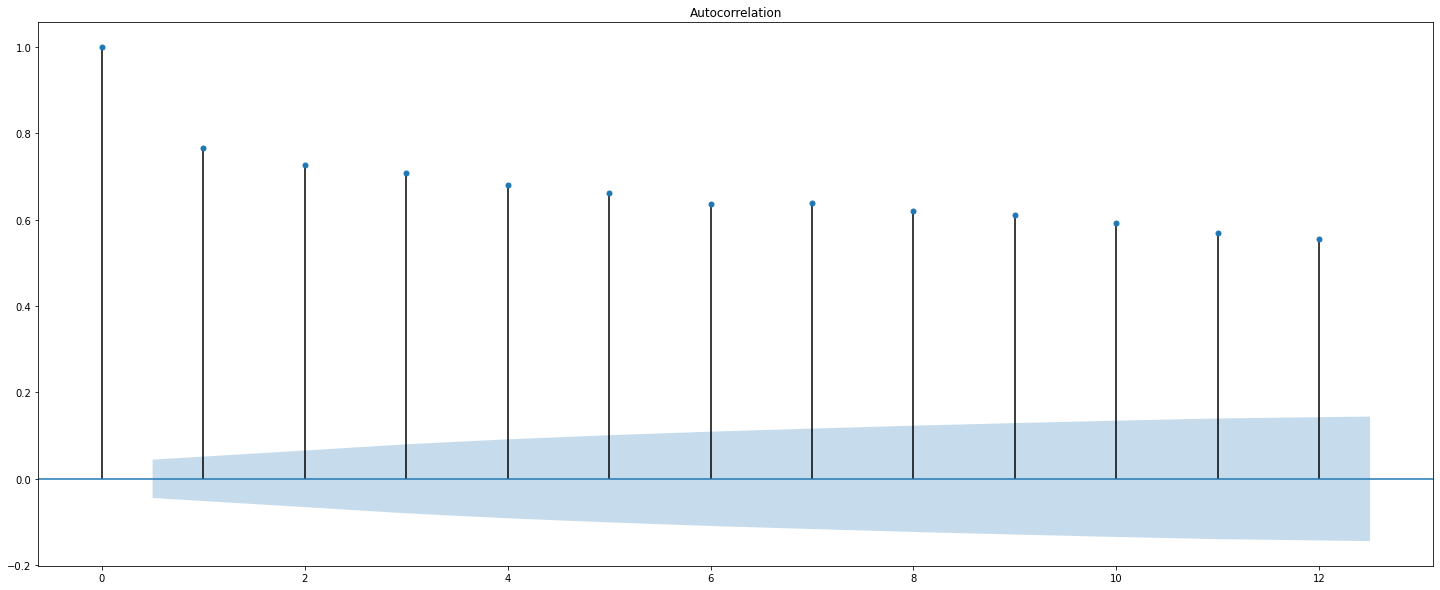

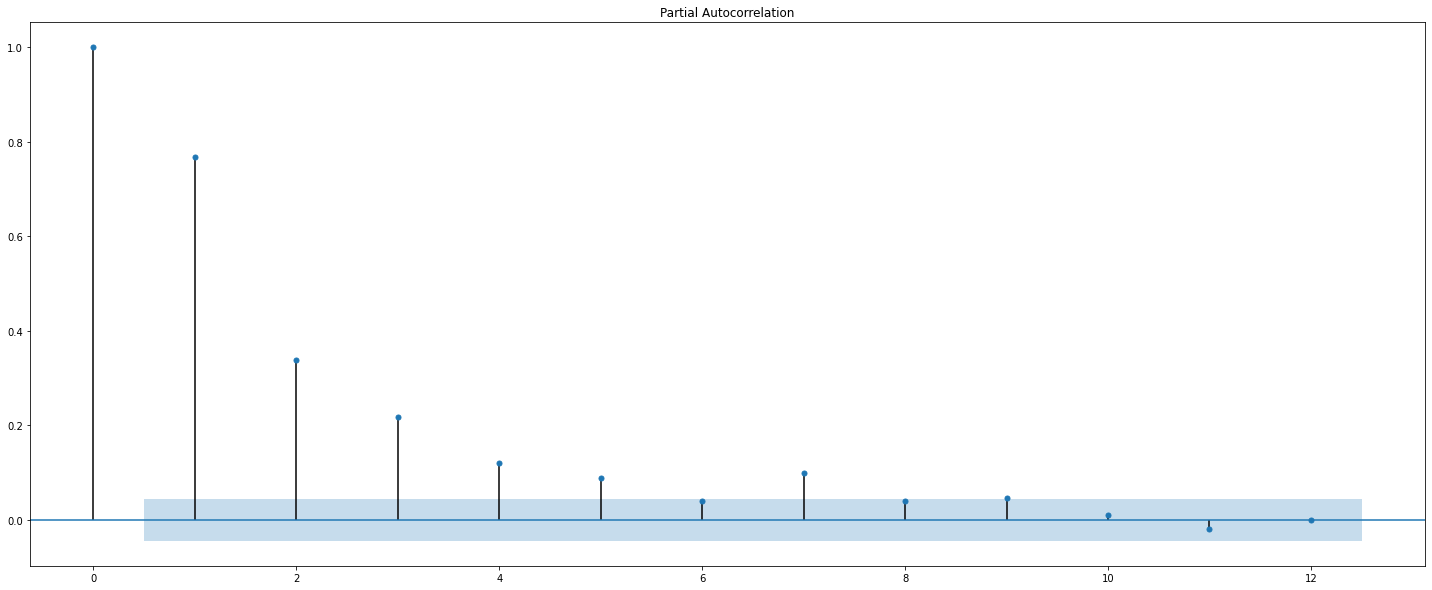

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_acf,ax_acf = plt.subplots(figsize=(25, 10))
fig_pacf,ax_pacf = plt.subplots(figsize=(25, 10))
plot_acf(ts, lags =12, ax=ax_acf)
plot_pacf(ts, lags =12, ax=ax_pacf)
plt.show()

In [93]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)

train = ts_trend[:train_end]
test = ts_trend[train_end + timedelta(days=1): test_end]
print(len(train))
print(len(test))
ts_trend

1765
61


Data
2015-01-01    143.435616
2015-01-02    143.380822
2015-01-03    143.326027
2015-01-04    143.271233
2015-01-05    143.216438
                 ...    
2020-04-26    135.536986
2020-04-27    135.526027
2020-04-28    135.515068
2020-04-29    135.504110
2020-04-30    135.493151
Name: trend, Length: 1947, dtype: float64

In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 7
q = 12
d = 1

#S = 365

model = SARIMAX(train, order=(p, d, q), 
                #seasonal_order=(0, 1, 0, S)
               )
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 1765
Model:              SARIMAX(7, 1, 12)   Log Likelihood                2796.788
Date:                Fri, 17 Jul 2020   AIC                          -5553.576
Time:                        17:02:30   BIC                          -5444.069
Sample:                    01-01-2015   HQIC                         -5513.111
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1121      0.816      0.137      0.891      -1.487       1.711
ar.L2         -0.0296      0.701     -0.042      0.966      -1.404       1.345
ar.L3          0.6625      0.708      0.935      0.3

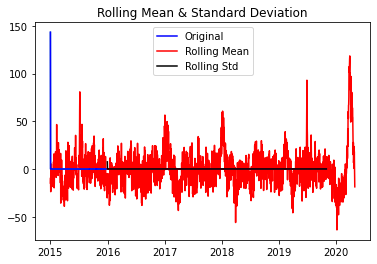

Results of Dickey-Fuller Test:
Test Statistic                -2894.221146
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [95]:
residuals = model_fit.resid
plt.plot(ts_residual, color='red')
plt.plot(residuals)
test_stationarity(residuals)

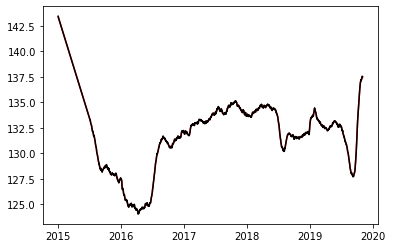

In [103]:
plt.plot(train.iloc[1:], color='red')
plt.plot(model_fit.fittedvalues.iloc[1:],color='black')
plt.show()

In [99]:
model_fit.fittedvalues

Data
2015-01-01      0.000000
2015-01-02    143.435617
2015-01-03    143.344775
2015-01-04    143.283717
2015-01-05    143.226406
                 ...    
2019-10-27    137.400697
2019-10-28    137.435634
2019-10-29    137.560017
2019-10-30    137.540739
2019-10-31    137.523142
Length: 1765, dtype: float64

In [100]:
train

Data
2015-01-01    143.435616
2015-01-02    143.380822
2015-01-03    143.326027
2015-01-04    143.271233
2015-01-05    143.216438
                 ...    
2019-10-27    137.386301
2019-10-28    137.487671
2019-10-29    137.509589
2019-10-30    137.498630
2019-10-31    137.441096
Name: trend, Length: 1765, dtype: float64

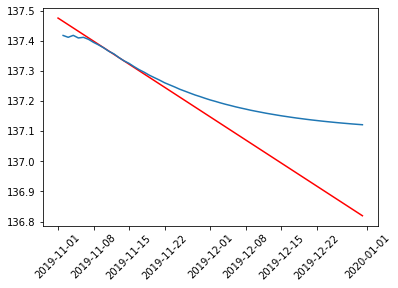

In [105]:
# predizioni sul test set
predictions = model_fit.forecast(steps=len(test))
plt.plot(test, color='red')
plt.plot(predictions.iloc[1:])
plt.xticks(rotation=45)
plt.show()

In [80]:
predictions

2015-07-03    133.463014
2015-07-04    133.373729
2015-07-05    133.316216
2015-07-06    133.265616
2015-07-07    133.264540
                 ...    
2019-10-29    137.553525
2019-10-30    137.541464
2019-10-31    137.521979
2019-11-01    137.428943
2019-11-02    137.422785
Freq: D, Length: 1584, dtype: float64